In [285]:
import cv2
import itertools
import numpy as np
import os
import sys

from scipy.spatial import ConvexHull, convex_hull_plot_2d

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import create_map
from src.create_map import load_obstacles
from src.create_map import load_goal
from src.create_map import map2img

In [254]:
from collections import namedtuple
Point = namedtuple('Point', 'x, y')

In [26]:
obstacles = load_obstacles("../data/world_obstacles.txt")

In [ ]:
# The map we use in RViz is 1200cm by 600cm, 
# top left and bottom right are (-300, 300) and (900, -300) respectively. 

# Also note that cells in the RViz grid are 50cm by 50cm, 
# The start position of the robot is always at (0, 0), 
# facing x-positive and the goal is defined in data/goal.txt. 
# assume the robot to be a 36cm-by-36cm square

# The obstacles are orange polygons and the goal is a purple dot. 

# More about using the map_server package here.

# robot to be a 36cm-by-36cm square.

In [72]:
# for each obstacle, generate four squares which adds the padding of 18 - 18 to each point of the obstacle

In [27]:
obstacles

[[[100, 0], [100, 50], [150, 0]],
 [[225, 25], [275, 25], [325, -25], [275, -75]],
 [[450, 30], [450, 130], [525, 130], [525, 30]],
 [[400, -50], [400, -100], [425, -50]],
 [[300, 100], [300, 150], [350, 150], [350, 100]]]

In [28]:
goal = load_goal("../data/goal.txt")

In [30]:
start = [0, 0]

In [273]:
# get expanded obstacles
hulls = []
temp_obstacles = []
grown_obstacles = []
padded_simplices = []
for obstacle in obstacles:
    expanded_obstacles = []
    for point in obstacle:
        expanded_obstacles.append(point)
        expanded_obstacles.append([point[0] - 18, point[1] - 18])
        expanded_obstacles.append([point[0] + 18, point[1] + 18])
        expanded_obstacles.append([point[0] + 18, point[1] - 18])
        expanded_obstacles.append([point[0] - 18, point[1] + 18])
    expanded_obstacles = np.array(expanded_obstacles)
    temp_obstacles.append(expanded_obstacles)
    hull = ConvexHull(expanded_obstacles)
    
    x = expanded_obstacles[hull.vertices, 0]
    y = expanded_obstacles[hull.vertices, 1]
    points = np.stack((x, y), axis=-1)
    grown_obstacles.append(points)
    
    simplices = np.stack((expanded_obstacles[hull.simplices, 0], 
                          expanded_obstacles[hull.simplices, 1]), 
                         axis=1)
    padded_simplices.append(simplices)
    
    hulls.append(hull)

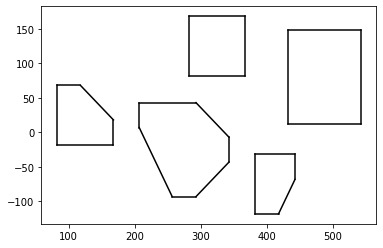

In [253]:
for idx, simplices in enumerate(padded_simplices):
    for simplex in simplices:
        plt.plot(simplex[0], simplex[1], 'k-')

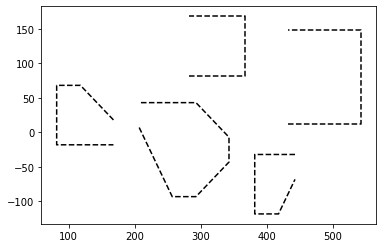

In [274]:
for obstacle in padded_obstacles:
    plt.plot(obstacle[:,0], obstacle[:,1], '--k')

In [395]:
# for collision detection: checking if line segments intersect

class Direction:
    CLOCKWISE = 0
    ANTI_CLOCKWISE = 1
    COLINEAR = 2
    
EPSILON = 0

def point_lie_on_segment(point1, point2, point3, epsilon=EPSILON):
    if min(point1.x, point2.x) - epsilon <= point3.x <= max(point1.x, point2.x) + epsilon and \
        min(point1.y, point2.y) - epsilon <= point3.y <= max(point1.y, point2.y) + epsilon :
        return True
    return False

def compute_orientation(point1, point2, point3, epsilon=EPSILON):
    cross_product = (point2.y - point1.y) * (point3.x - point2.x) -  (point2.x - point1.x) * (point3.y - point2.y)
    
    if abs(cross_product) <= epsilon:
        return Direction.COLINEAR
    elif cross_product > 0:
        return Direction.CLOCKWISE
    elif cross_product < 0:
        return Direction.ANTI_CLOCKWISE

def segment_intersect(point1, point2, point3, point4, epsilon = EPSILON):
    orientation1 = compute_orientation(point1, point2, point3)
    orientation2 = compute_orientation(point1, point2, point4)
    orientation3 = compute_orientation(point3, point4, point1)
    orientation4 = compute_orientation(point3, point4, point2)
    
    if orientation1 != orientation2 and orientation3 != orientation4:
        return True
    
    if orientation1 == Direction.COLINEAR and  point_lie_on_segment(point1, point2, point3, epsilon):
        return True
    
    if orientation2 == Direction.COLINEAR and point_lie_on_segment(point1, point2, point4, epsilon):
        return True

    if orientation3 == Direction.COLINEAR and point_lie_on_segment(point3, point4, point1, epsilon):
        return True
    
    if orientation4 == Direction.COLINEAR and point_lie_on_segment(point3, point4, point2, epsilon):
        return True
    
    return False

In [265]:
start

[0, 0]

In [263]:
goal

[600, 0]

In [280]:
obstacle_points = []
for obs in grown_obstacles:
    obs_points = []
    for point in obs:
        obs_points.append(Point(*point))
    obstacle_points.append(obs_points)
obstacle_points

[[Point(x=168, y=18),
  Point(x=118, y=68),
  Point(x=82, y=68),
  Point(x=82, y=-18),
  Point(x=168, y=-18)],
 [Point(x=207, y=7),
  Point(x=257, y=-93),
  Point(x=293, y=-93),
  Point(x=343, y=-43),
  Point(x=343, y=-7),
  Point(x=293, y=43),
  Point(x=207, y=43)],
 [Point(x=432, y=12),
  Point(x=543, y=12),
  Point(x=543, y=148),
  Point(x=432, y=148)],
 [Point(x=443, y=-32),
  Point(x=382, y=-32),
  Point(x=382, y=-118),
  Point(x=418, y=-118),
  Point(x=443, y=-68)],
 [Point(x=282, y=82),
  Point(x=368, y=82),
  Point(x=368, y=168),
  Point(x=282, y=168)]]

In [295]:
obstacle_points[0]

[Point(x=168, y=18),
 Point(x=118, y=68),
 Point(x=82, y=68),
 Point(x=82, y=-18),
 Point(x=168, y=-18)]

In [393]:
# computing line segments for convex hull edge
obstacle_edges = []

# iterate for every obstacle point collections
for obs in obstacle_points:
    obs_point_segments = [(obs[i], obs[i+1]) for i in range(len(obs) - 1) ]
    if len(obs) > 2:
        obs_point_segments.append((obs[-1], obs[0]))
    obstacle_edges.append(obs_point_segments)
obstacle_edges

[[(Point(x=168, y=18), Point(x=118, y=68)),
  (Point(x=118, y=68), Point(x=82, y=68)),
  (Point(x=82, y=68), Point(x=82, y=-18)),
  (Point(x=82, y=-18), Point(x=168, y=-18)),
  (Point(x=168, y=-18), Point(x=168, y=18))],
 [(Point(x=207, y=7), Point(x=257, y=-93)),
  (Point(x=257, y=-93), Point(x=293, y=-93)),
  (Point(x=293, y=-93), Point(x=343, y=-43)),
  (Point(x=343, y=-43), Point(x=343, y=-7)),
  (Point(x=343, y=-7), Point(x=293, y=43)),
  (Point(x=293, y=43), Point(x=207, y=43)),
  (Point(x=207, y=43), Point(x=207, y=7))],
 [(Point(x=432, y=12), Point(x=543, y=12)),
  (Point(x=543, y=12), Point(x=543, y=148)),
  (Point(x=543, y=148), Point(x=432, y=148)),
  (Point(x=432, y=148), Point(x=432, y=12))],
 [(Point(x=443, y=-32), Point(x=382, y=-32)),
  (Point(x=382, y=-32), Point(x=382, y=-118)),
  (Point(x=382, y=-118), Point(x=418, y=-118)),
  (Point(x=418, y=-118), Point(x=443, y=-68)),
  (Point(x=443, y=-68), Point(x=443, y=-32))],
 [(Point(x=282, y=82), Point(x=368, y=82)),
  (Poi

In [388]:
# computing line segments for one convex hull edge
obs_point_segments = [(obstacle_points[0][i], obstacle_points[0][i+1]) for i in range(len(obstacle_points[0]) - 1) ]
if len(obstacle_points[0]) > 2:
    obs_point_segments.append((obstacle_points[0][-1], obstacle_points[0][0]))
obs_point_segments

[(Point(x=168, y=18), Point(x=118, y=68)),
 (Point(x=118, y=68), Point(x=82, y=68)),
 (Point(x=82, y=68), Point(x=82, y=-18)),
 (Point(x=82, y=-18), Point(x=168, y=-18)),
 (Point(x=168, y=-18), Point(x=168, y=18))]

In [352]:
# from start point to points in convex hull
start_obs_segments = [(start_point, obs_point) for obs_point in obstacle_points[0]]
start_obs_segments

[(Point(x=0, y=0), Point(x=168, y=18)),
 (Point(x=0, y=0), Point(x=118, y=68)),
 (Point(x=0, y=0), Point(x=82, y=68)),
 (Point(x=0, y=0), Point(x=82, y=-18)),
 (Point(x=0, y=0), Point(x=168, y=-18))]

In [330]:
# start_obs_segments[0]

(Point(x=0, y=0), Point(x=168, y=18))

In [347]:
[i for i in range(10)][0:-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [391]:
lines_not_intersect = []
for idx1, start_obs_segment in enumerate(start_obs_segments):
    intersect = False

    for obs_point_segment in checked_segments:
        # skip checks if the end point of the start point is the same as the start or end of the obstacle segment
        if point_lie_on_segment(obs_point_segment[0], obs_point_segment[1], start_obs_segment[1]):
            continue
            
        intersect = segment_intersect(*start_obs_segment, *obs_point_segment)
        if intersect:
            break

    if not intersect:
        lines_not_intersect.append(start_obs_segment)

lines_not_intersect

[(Point(x=0, y=0), Point(x=82, y=68)), (Point(x=0, y=0), Point(x=82, y=-18))]

In [ ]:
# 1) connect the points, from start point to every point in convex hull and goal
# and from every point of convex hull to other points in other convex hulls and goal
# 2) remove unseen lines, by removing the edges that intersect with the convex hull edge
# 3) special case: check from start to goal with all other points in convex

In [101]:
def plot_map(start, goal, obstacles):
    # Create a black image
    img = np.full((600, 1200, 3), 255, np.uint8)

    obs = []
    # draw obstacles
    for ob in obstacles:
        ob = map2img(ob)
        obs.append(ob)
        # print(len(ob))
        # print(ob)
        cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

    # draw start and goal point
    goal_img = tuple(map2img([goal])[0])
    start_img = tuple(map2img([start])[0])
    circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
    circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)
    
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()

In [63]:
# Create a black image
img = np.full((600, 1200, 3), 255, np.uint8)
    
obs = []
# draw obstacles
for ob in obstacles:
    ob = map2img(ob)
    obs.append(ob)
    # print(len(ob))
    # print(ob)
    cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

# draw start and goal point
goal_img = tuple(map2img([goal])[0])
start_img = tuple(map2img([start])[0])
circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)

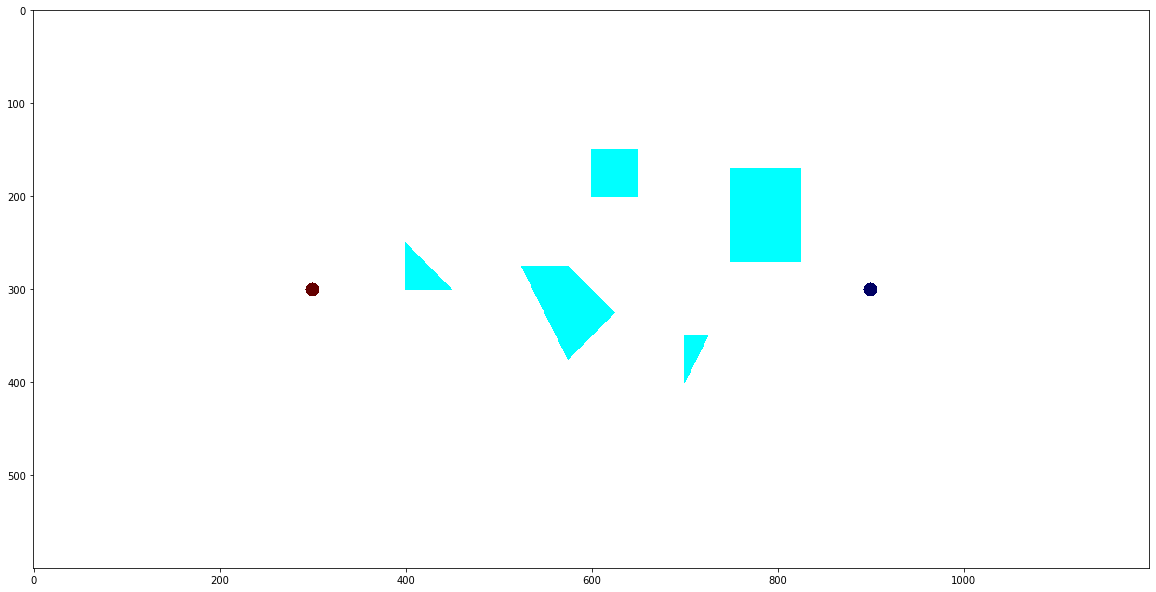

In [58]:
fig = plt.figure(figsize=(20, 20))
# ax = fig.gca()
# ax.set_xticks(np.arange(0, 1, 1))
# ax.set_yticks(np.arange(0, 1, 1))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

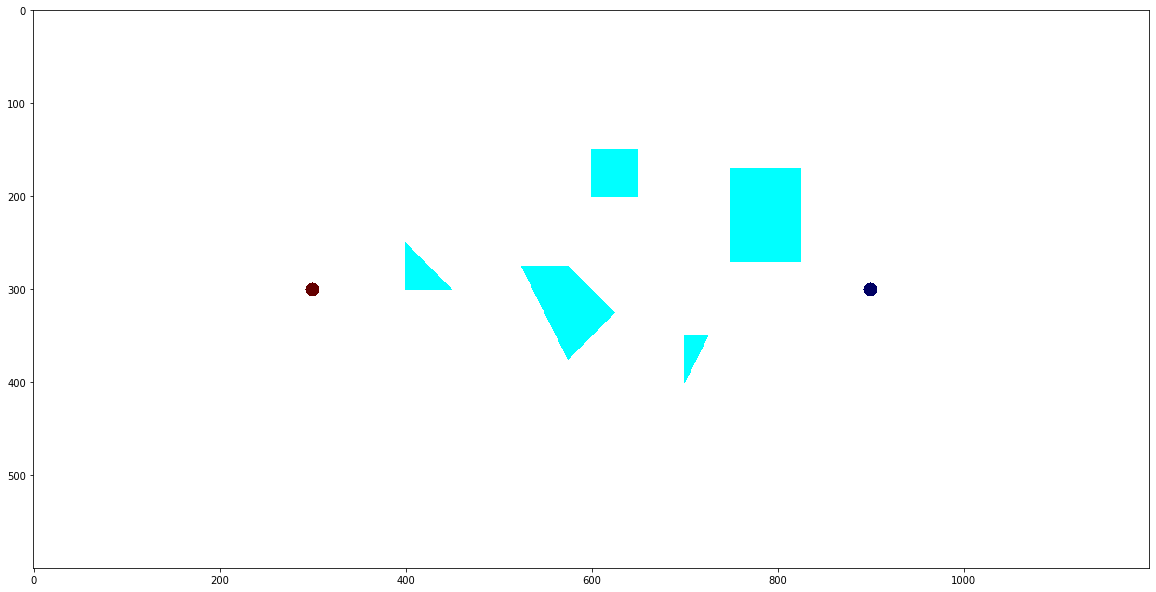

In [105]:
# Create a black image
img = np.full((600, 1200, 3), 255, np.uint8)

obs = []
# draw obstacles
for ob in obstacles:
    ob = map2img(ob)
    obs.append(ob)
    # print(len(ob))
    # print(ob)
    cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

# draw start and goal point
goal_img = tuple(map2img([goal])[0])
start_img = tuple(map2img([start])[0])
circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)

fig = plt.figure(figsize=(20, 20))
ax = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

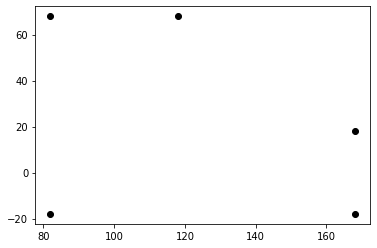

In [116]:
boundary_points = hulls[0].points[hulls[0].vertices]
plt.plot(boundary_points[:,0], boundary_points[:,1], 'ko')

In [112]:
a

array([168., 118.,  82.,  82., 168.])

In [117]:
hulls[0].equations

array([[   0.70710678,    0.70710678, -131.5218613 ],
       [  -0.        ,   -1.        ,  -18.        ],
       [   1.        ,    0.        , -168.        ],
       [  -1.        ,    0.        ,   82.        ],
       [  -0.        ,    1.        ,  -68.        ]])

In [107]:
hulls[0].vertices

array([12,  7,  9,  1, 13], dtype=int32)